## Introduction

Business scenario:
Lease Plan provides leased cars to large corporations. They have a a need to determine the typical maintenance schedule and costs for vehicles leased in a fleet so they can set appropriate pricing in their lease contracts.  In addition they need to look for anomalous maintenance contracts for fraud or for consistent over charging for parts or labor.

Data:
Lease Plane has transactional level data around vehicle servicing which includes schedule/unscheduled services. Scheduled services are things like oil change, breaks, ect. Unscheduled services would be something that is found broken during a scheduled servicing that wasn’t scheduled to be fixed, or something the is broken and brought in for an unscheduled maintenance.

Each service history (list of maintenance records) for a car contains:

* scheduled maintenance records (with scheduled & unscheduled maintenance items)
* unscheduled maintenance records (with scheduled & unscheduled maintenance items)

Each maintenance record contains:

* region 
* nature of business of leasor
* age of vehicle in vehicle miles, as well as absolute age
* vehicle make, model, year
* repair location
* line items
    * category of repair (well defined set)
    * description of repair
    * repair costs
    * parts/ versus labor breakdown

On issue is that next years model, they can use previous years data, but for brand new vehicle categories like hybrid or electric, they will not have allot of data. 

Some fleets of vehicles will have much higher utilisation than others, so their data can be used to predict the future of of the less utilised vehicle fleets.


Desired Outcome:
The desired outcome is to right size the lease costs so they don’t overprice leases and can remain competitive, as well as keep their margins above the actual repair costs. Another objective is to detect anomalous unscheduled maintenance tasks or labor costs.


## Helper functions

In [1]:
def get_col_with_null(df):
    series = raw_data.isnull().sum()
    null_col = series[series != 0].index
    
    return list(null_col)



## Data Exploration


In [2]:
# Define IAM role
import boto3
import re
import io
import botocore

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 101

In [5]:
bucket = 'leaseplan-oct-2019-ml-immersion'
prefix = 'lease-plan'
filename = 'sample_data.csv'
s3_fullpath = os.path.join('s3://', bucket, prefix, 'raw-data', filename)

!aws s3 cp $s3_fullpath .

download: s3://leaseplan-oct-2019-ml-immersion/lease-plan/raw-data/sample_data.csv to ./sample_data.csv


In [6]:
# Read from S3 or local
raw_data = pd.read_csv(filename, header=0, sep=',')
print(raw_data.shape)
raw_data.head()


(100, 29)


,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder
0,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER - SUMP PLUG,1 ST,0.000,1.320,0.000,1.320,130.910
1,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER ADDITIVE,1 ST,0.000,0.000,0.000,0.000,130.910
2,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WORKSHOP SUPPLIES,1 ST,0.000,8.010,0.000,8.010,130.910
3,161531,19MAY2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801232605,Budget,70000.000,70136,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,0.800,0.000,66.000,66.000,130.910
4,161531,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801369140,Budget,80000.000,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,DIFF OIL,1 L,0.000,26.100,0.000,26.100,405.410


### Null values

In [7]:
raw_data.isnull().sum()

iobjectid                   0
jobdate                     0
terminationflag             0
terminationtype             0
contractstartdateorig       0
contractenddate             0
lastknownododate            0
builddate                   0
customertopnode             0
make                        0
model                       0
vehicledesc                 0
bodytype                    0
serviceorderid              0
accountingindicator         0
serviceinterval             8
odometer                    0
supplierpostcode            0
industry_desc               0
industry_code              38
contractserviceitem         0
servicetype                 0
productshorttext            0
quantity                    0
supplier_srt               38
partscost                   0
labourcost                  0
costexcgst                  0
totalcostbyserviceorder     0
dtype: int64

In [8]:
col_with_null = get_col_with_null(raw_data)
print(col_with_null)

['serviceinterval', 'industry_code', 'supplier_srt']


In [9]:
# replace null col with 0
raw_data[col_with_null] = raw_data[col_with_null].fillna(0) 

In [10]:
# Drop column with null values
# raw_data = raw_data.drop(col_with_null, axis=1)
# raw_data.head()

### Numerical features

iobjectid, serviceorderid
- Not really unique number, hence keep

customertopnode, supplierpostcode, industry_code
- Convert to categorical

In [11]:
num_features = raw_data.select_dtypes(exclude='object').columns
raw_data[num_features].describe()

,iobjectid,customertopnode,serviceorderid,serviceinterval,odometer,supplierpostcode,industry_code,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,161535.060,1000002983.490,2801573755.140,67900.000,69554.270,3777.710,1030.320,0.086,8.240,12.764,19.200,168.951
std,5.087,2075.246,356954.673,39062.111,38032.308,952.873,1069.725,0.317,19.930,27.891,36.272,148.433
min,161531.000,1000000349.000,2800297501.000,0.000,20951.000,2526.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,161531.000,1000000349.000,2801369140.000,30000.000,27720.000,2609.000,0.000,0.000,0.000,0.000,0.000,24.425
50%,161531.000,1000004617.000,2801574869.000,80000.000,80328.000,4551.000,1515.000,0.000,0.000,0.000,0.000,139.450
75%,161541.000,1000004617.000,2801843681.000,100000.000,103296.000,4551.000,1515.000,0.000,7.433,9.910,16.375,258.267
max,161550.000,1000004617.000,2802136575.000,120000.000,120241.000,4551.000,8083.000,1.600,142.710,132.000,157.500,405.410


In [12]:
for col in num_features:
    print("***********Column: " + col + "**********")
    print(raw_data[col].value_counts())
    print('Unique: ', len(raw_data[col].unique()))
    


***********Column: iobjectid**********
161531    60
161541    38
161550     1
161538     1
Name: iobjectid, dtype: int64
Unique:  4
***********Column: customertopnode**********
1000004617    60
1000000349    38
1000004428     1
1000003639     1
Name: customertopnode, dtype: int64
Unique:  4
***********Column: serviceorderid**********
2801369140    13
2801843681    12
2801746385    12
2802053131    12
2801375870    10
2800998847    10
2801574869     9
2801854505     9
2801232605     4
2800999014     2
2801541346     2
2802136575     1
2800970230     1
2801949663     1
2801881685     1
2800297501     1
Name: serviceorderid, dtype: int64
Unique:  16
***********Column: serviceinterval**********
80000.000     13
120000.000    12
100000.000    12
40000.000     12
30000.000     10
20000.000     10
110000.000     9
90000.000      9
0.000          8
70000.000      4
50000.000      1
Name: serviceinterval, dtype: int64
Unique:  11
***********Column: odometer**********
80328     13
28446     13
2

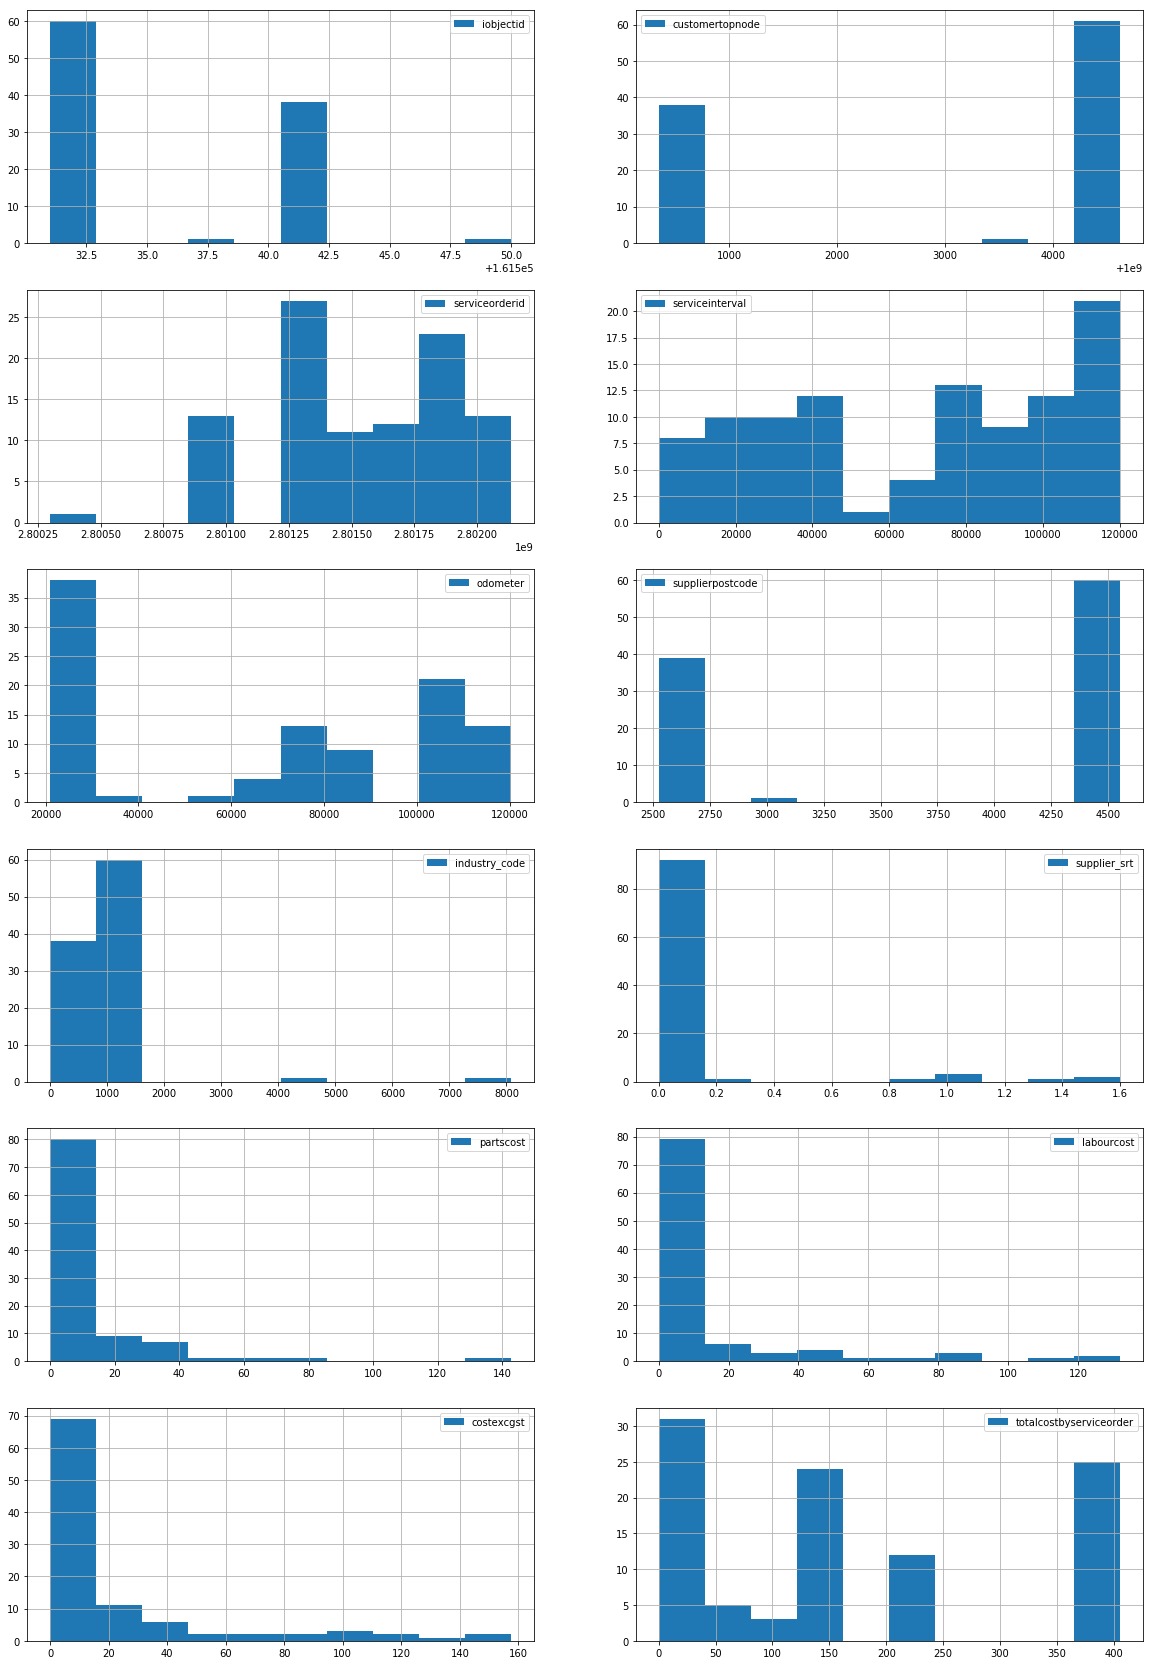

In [13]:
fig, ax = plt.subplots(nrows=int(len(num_features)/2), ncols=2, figsize=(20, 30))

for i, col in enumerate(num_features):

    ax[int(i/2),int(i%2)].hist(raw_data[col], label=col)  
    ax[int(i/2),int(i%2)].grid()
    ax[int(i/2),int(i%2)].legend()

plt.show()

Keep only the first 2 digits of post code

In [14]:
raw_data['supplierpostcode'] = raw_data['supplierpostcode'].apply(lambda x: int(x / 100))


### Categorical features

In [15]:
cat_features = raw_data.select_dtypes(include='object').columns

assert(len(cat_features)+len(num_features) == len(raw_data.columns))

In [16]:
raw_data[cat_features].describe()

,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,make,model,vehicledesc,bodytype,accountingindicator,industry_desc,contractserviceitem,servicetype,productshorttext,quantity
count,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
unique,15,1,1,3,3,4,4,2,4,4,4,1,4,4,4,21,18
top,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,Budget,Construction: Building - General Contrac,Maintenance Budgeted Premium,Scheduled,Scheduled,1 ST
freq,13,100,100,98,98,60,60,99,60,60,60,100,60,55,57,30,50


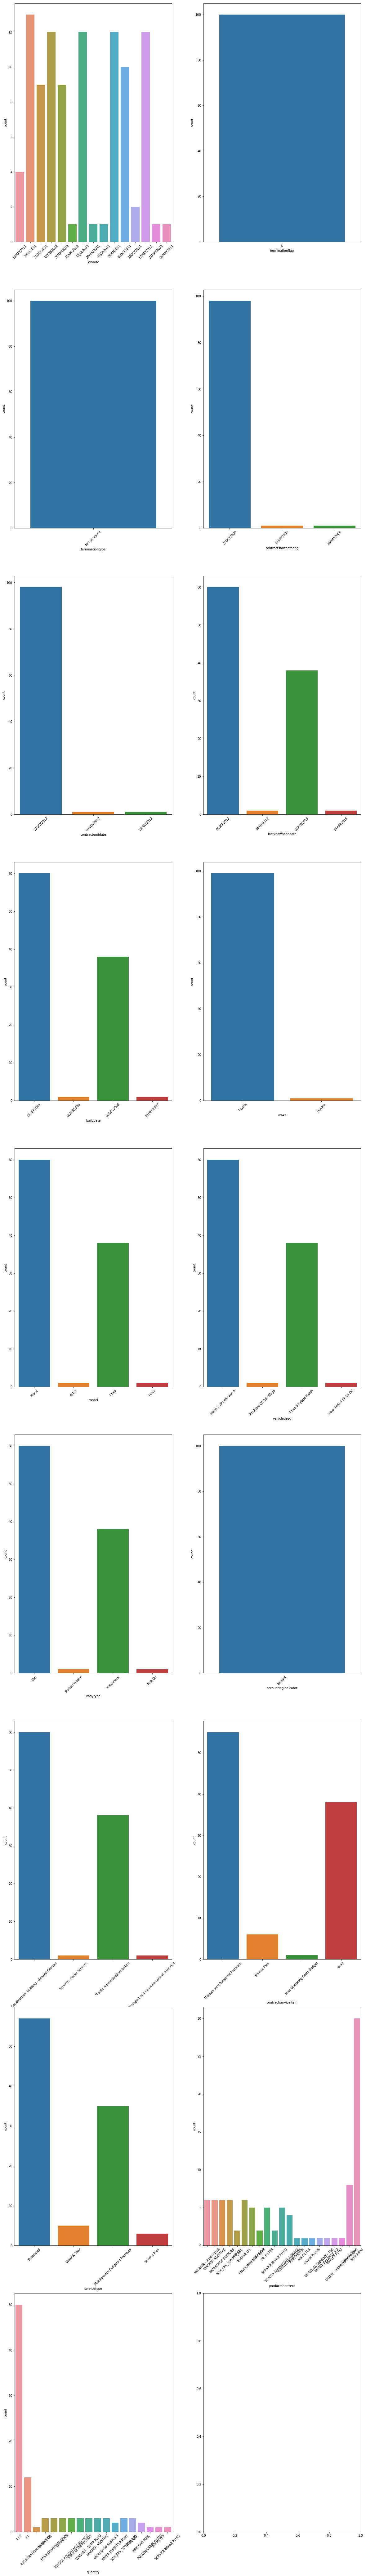

In [17]:
import seaborn as sns
from math import ceil    

fig, ax = plt.subplots(nrows=ceil(len(cat_features)/2), ncols=2, figsize=(20, 150))

for i, col in enumerate(cat_features):
    cur_ax = sns.countplot(x=col, data=raw_data,ax=ax[int(i/2),int(i%2)])
    cur_ax.tick_params(axis='x', rotation=45)
    
plt.show()

In [18]:
# Show top 5 categorical values
for col in cat_features:
    print("***********Column: " + col + "**********")
    print(raw_data[col].value_counts()[:5])

***********Column: jobdate**********
26JUL2011    13
17MAY2012    12
28JAN2011    12
07FEB2012    12
12JUL2012    12
Name: jobdate, dtype: int64
***********Column: terminationflag**********
#    100
Name: terminationflag, dtype: int64
***********Column: terminationtype**********
Not assigned    100
Name: terminationtype, dtype: int64
***********Column: contractstartdateorig**********
23OCT2009    98
04SEP2008     1
26MAY2008     1
Name: contractstartdateorig, dtype: int64
***********Column: contractenddate**********
22OCT2012    98
25MAY2012     1
03NOV2012     1
Name: contractenddate, dtype: int64
***********Column: lastknownododate**********
06SEP2012    60
01APR2013    38
04SEP2012     1
01APR2015     1
Name: lastknownododate, dtype: int64
***********Column: builddate**********
01SEP2009    60
01DEC2008    38
01APR2008     1
01DEC2007     1
Name: builddate, dtype: int64
***********Column: make**********
Toyota    99
Holden     1
Name: make, dtype: int64
***********Column: model*****